In [1]:
# Load all the necessary Libraries

# Base Libraries
import numpy as np
import pandas as pd

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime
import datetime as dt

# Warnings Library - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

### Import the dataset

In [2]:
timeseries = pd.read_csv("data_stocks.csv")

In [3]:
timeseries.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


### Extract The following columns
<b>NASDAQ.AAPL<br>
NASDAQ.ADP<br>
NASDAQ.CBOE<br>
NASDAQ.CSCO<br>
NASDAQ.EBAY</b>

In [4]:
timeSeries_Extract = timeseries[["DATE","NASDAQ.AAPL","NASDAQ.ADP","NASDAQ.CBOE","NASDAQ.CSCO","NASDAQ.EBAY"]]

In [5]:
timeSeries_Extract.head()

,DATE,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY
0,1491226200,143.6800,102.2300,81.03,33.7400,33.3975
1,1491226260,143.7000,102.1400,81.21,33.8800,33.3950
2,1491226320,143.6901,102.2125,81.21,33.9000,33.4100
3,1491226380,143.6400,102.1400,81.13,33.8499,33.3350
4,1491226440,143.6600,102.0600,81.12,33.8400,33.4000


### DATA SANITY CHECKS

In [6]:
# Check if there are any nulls
timeSeries_Extract.isnull().sum().sum()

0

In [7]:
# Check if Nonsense values. Like the values that are less than 0
timeSeries_Extract[timeSeries_Extract<0].any().sum()

0

### CONVERT DATE COLUMN TO DATE

In [8]:
timeSeries_Extract["Date"] = timeSeries_Extract["DATE"].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))


In [9]:
# Drop the original DATE Column
timeSeries_Extract.drop("DATE", axis=1, inplace=True)

In [10]:
timeSeries_merged = timeSeries_Extract.groupby("Date", as_index=True).mean()

In [11]:
timeSeries_merged.head()

,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY
Date,,,,,
2017-04-03,143.611617,101.535394,80.634058,33.599837,33.549299
2017-04-04,144.070175,101.172985,80.547717,33.343796,33.867744
2017-04-05,145.060110,102.247928,80.996049,33.374008,34.335381
2017-04-06,144.204440,101.885143,80.490569,33.122422,34.038002
2017-04-07,143.798136,101.836214,80.478171,33.039277,33.956909


In [12]:
# Reset date as the index
# timeSeries_Extract = timeSeries_Extract.set_index("Date")

In [13]:
# Check how many distict years there is. There is just one year : 2017
timeseries["DATE"].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y')).value_counts()

2017    41266
Name: DATE, dtype: int64

### PLOT THE GRAPH TO SEE IF THE DATA IS STATIONARY OR NON STATIONARY

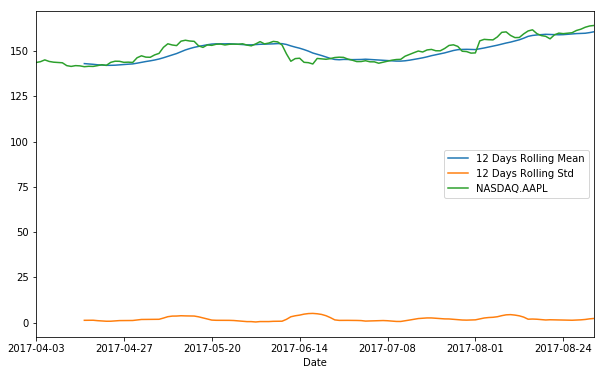

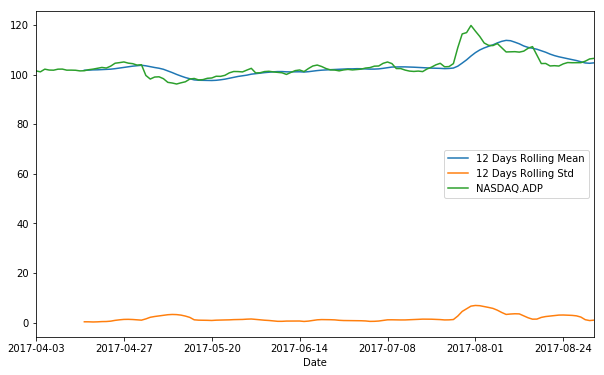

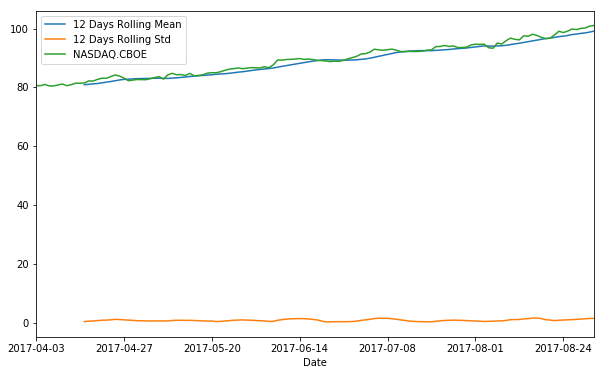

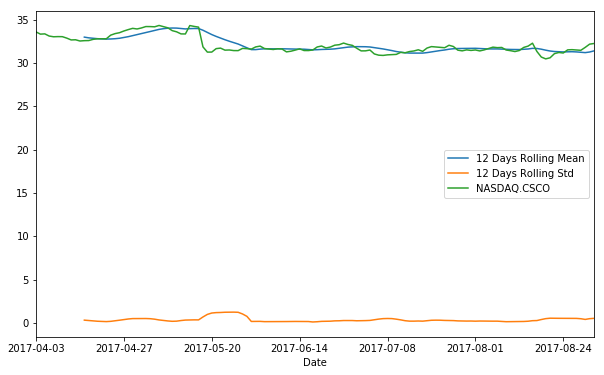

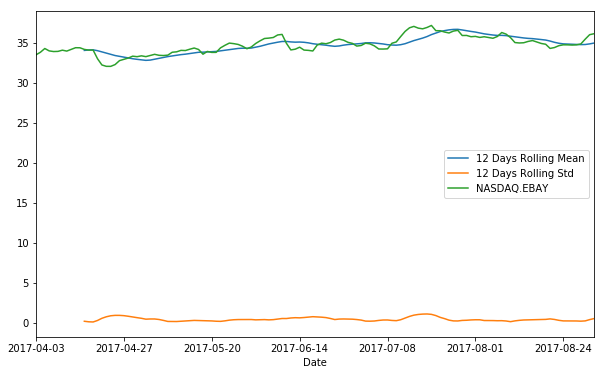

In [14]:
for i in range(0,5):
    plt.figure(figsize=(10,6))
    #plt.plot(timeSeries_Extract.iloc[:,i], color='blue', label='original')
    # The rolling mean/std because you need to plot mean against all the dates
    #timeSeries_Extract.iloc[:,i].rolling(window=12).mean().plot
    #timeSeries_Extract.iloc[:,i].plot()
    #timeSeries_Extract.iloc[:,1].rolling(window=1).std().plot()
    #plt.plot(roll_mean, color='red', label='mean')
    #plt.title(timeSeries_Extract.columns[i])
    timeSeries_merged.iloc[:,i].rolling(12).mean().plot(label='12 Days Rolling Mean')
    timeSeries_merged.iloc[:,i].rolling(12).std().plot(label='12 Days Rolling Std')
    timeSeries_merged.iloc[:,i].plot()
    plt.legend()

### Conclusion:

Clearly from the visuals the dataset is not Non-Stationary

### DICKEY FULLER MODEL

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
import statsmodels

In [16]:
# Create a function to get the p values
def stationary_check(timeseries):
    
    result = adfuller(timeseries)
    
    print ('Augumented Dikey-Fuller Test : ')
    labels = ['ADF Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print (label + ' : ' + str(value))

    if result[1] < 0.05:
        print ("Null Hypothesis Rejected : Data is Stationary")
    else:
        print ("Null Hypothesis Not Rejected : Data is Non Stationary")

In [17]:
# Pull out the values for each
for i in range(0,5):
    # print ("***" * 6 + " " + timeSeries_Extract.columns[i] + " " + "***"*6)
    # stationary_check(timeSeries_Extract.iloc[:,i])
    print ("***" * 6 + " " + timeSeries_merged.columns[i] + " " + "***"*6)
    stationary_check(timeSeries_merged.iloc[:,i])
    print (' ')

****************** NASDAQ.AAPL ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -0.9537513071136212
p-value : 0.7697567138030207
#Lags Used : 5
Number of Observations Used : 122
Null Hypothesis Not Rejected : Data is Non Stationary
 
****************** NASDAQ.ADP ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -2.4741549511215735
p-value : 0.12189000022384189
#Lags Used : 1
Number of Observations Used : 126
Null Hypothesis Not Rejected : Data is Non Stationary
 
****************** NASDAQ.CBOE ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : 0.44551956399022136
p-value : 0.9831196818884852
#Lags Used : 0
Number of Observations Used : 127
Null Hypothesis Not Rejected : Data is Non Stationary
 
****************** NASDAQ.CSCO ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -1.7348938860684884
p-value : 0.41322965654199884
#Lags Used : 3
Number of Observations Used : 124
Null Hypothesis Not Rej

### Making Series Stationary

<b>Differencing</b><br>
The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

In [18]:
# Difference of 1
for i in range(0,5):
    # col_name = timeSeries_Extract.columns[i] + "diff_1"
    # timeSeries_Extract[col_name] = timeSeries_Extract[timeSeries_Extract.columns[i]] - timeSeries_Extract[timeSeries_Extract.columns[i]].shift(1)
    col_name = timeSeries_merged.columns[i] + "diff_1"
    timeSeries_merged[col_name] = timeSeries_merged[timeSeries_merged.columns[i]] - timeSeries_merged[timeSeries_merged.columns[i]].shift(1)

In [19]:
timeSeries_merged.head()

,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY,NASDAQ.AAPLdiff_1,NASDAQ.ADPdiff_1,NASDAQ.CBOEdiff_1,NASDAQ.CSCOdiff_1,NASDAQ.EBAYdiff_1
Date,,,,,,,,,,
2017-04-03,143.611617,101.535394,80.634058,33.599837,33.549299,NaN,NaN,NaN,NaN,NaN
2017-04-04,144.070175,101.172985,80.547717,33.343796,33.867744,0.458558,-0.362409,-0.086341,-0.256042,0.318446
2017-04-05,145.060110,102.247928,80.996049,33.374008,34.335381,0.989935,1.074944,0.448332,0.030212,0.467637
2017-04-06,144.204440,101.885143,80.490569,33.122422,34.038002,-0.855670,-0.362785,-0.505480,-0.251585,-0.297379
2017-04-07,143.798136,101.836214,80.478171,33.039277,33.956909,-0.406304,-0.048929,-0.012398,-0.083145,-0.081093


In [20]:
# Compute the P value
# Pull out the values for each
for i in range(5,10):
    # print ("***" * 6 + " " + timeSeries_Extract.columns[i] + " " + "***"*6)
    # stationary_check(timeSeries_Extract.iloc[:,i].dropna())
    print ("***" * 6 + " " + timeSeries_merged.columns[i] + " " + "***"*6)
    stationary_check(timeSeries_merged.iloc[:,i].dropna())
    print (' ')

****************** NASDAQ.AAPLdiff_1 ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -4.079679411979281
p-value : 0.001046202769755664
#Lags Used : 4
Number of Observations Used : 122
Null Hypothesis Rejected : Data is Stationary
 
****************** NASDAQ.ADPdiff_1 ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -7.194302423425574
p-value : 2.457381501251947e-10
#Lags Used : 0
Number of Observations Used : 126
Null Hypothesis Rejected : Data is Stationary
 
****************** NASDAQ.CBOEdiff_1 ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -11.310527291716381
p-value : 1.2422662761970767e-20
#Lags Used : 0
Number of Observations Used : 126
Null Hypothesis Rejected : Data is Stationary
 
****************** NASDAQ.CSCOdiff_1 ******************
Augumented Dikey-Fuller Test : 
ADF Test Statistics : -8.606316672126727
p-value : 6.657638268393473e-14
#Lags Used : 2
Number of Observations Used : 124
Null Hypothesis 

### Decompose the graph

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_data(series):
    decomposition = seasonal_decompose(series.dropna().values, freq=12)
    fig = plt.figure()
    fig = decomposition.plot()  
    fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

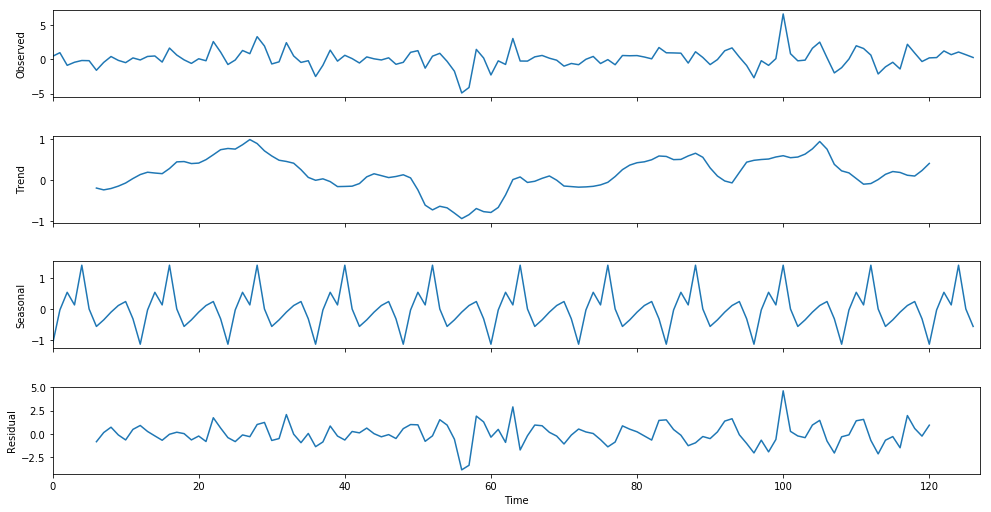

<Figure size 432x288 with 0 Axes>

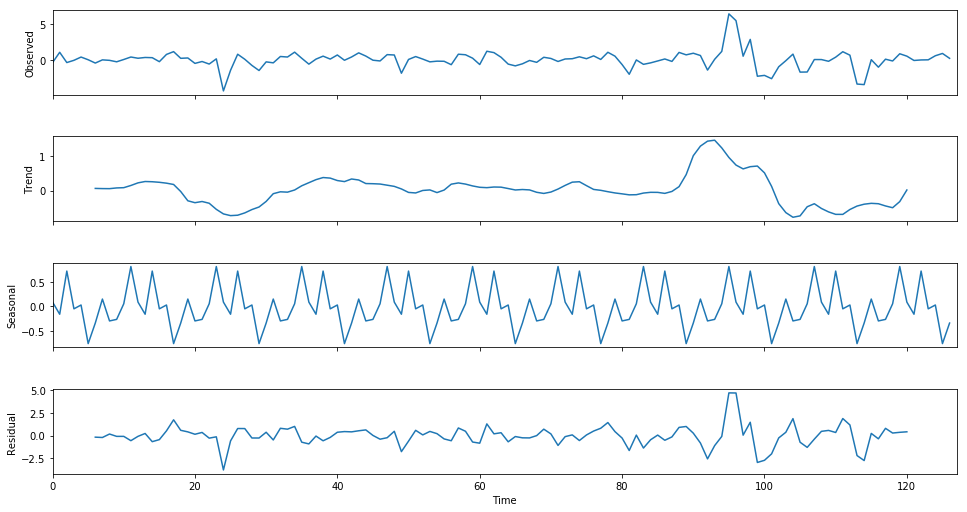

<Figure size 432x288 with 0 Axes>

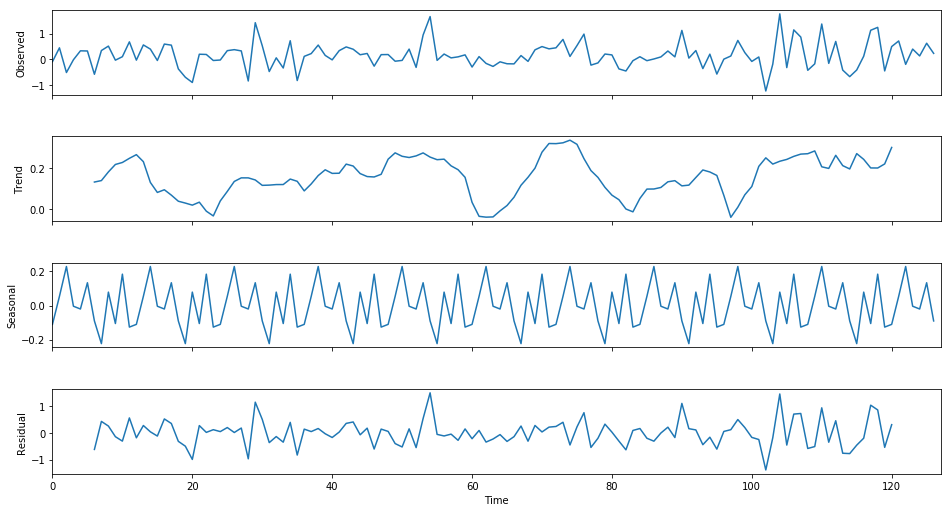

<Figure size 432x288 with 0 Axes>

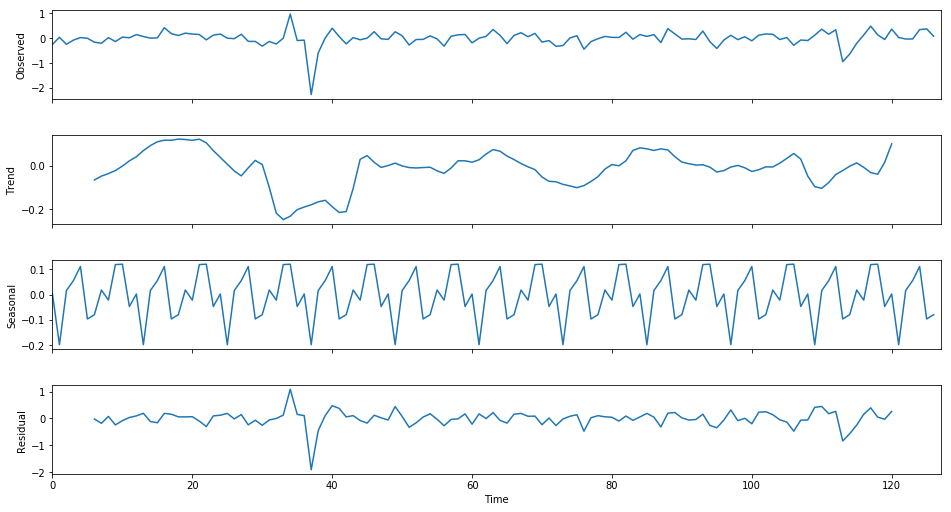

<Figure size 432x288 with 0 Axes>

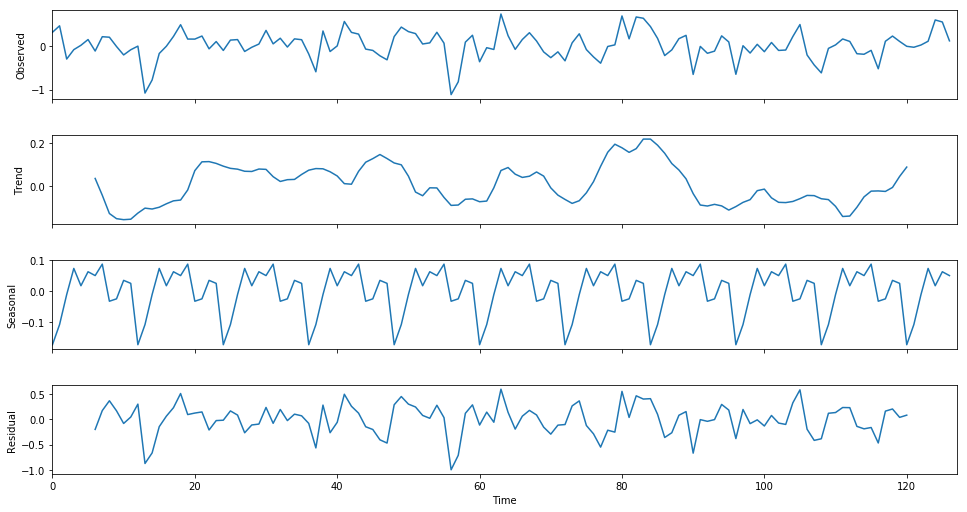

In [22]:
for i in range(5,10):
    decompose_data(timeSeries_merged.iloc[:,i])

#### NOTE
Clearly this is a seasonal Data

### NASDAQ.AAPL - Autocorrelation, Partial Autocorrelation Plots, ARIMA and Prediction

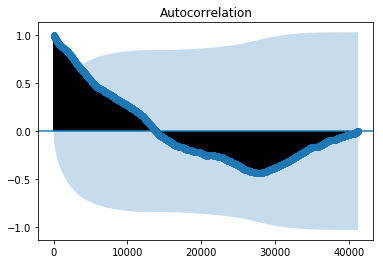

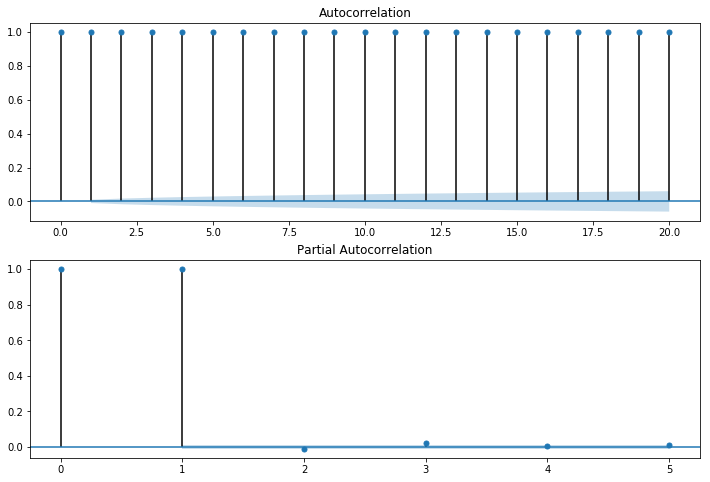

In [23]:
fig_first = plot_acf(timeseries.iloc[:,1])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries.iloc[:,1], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries.iloc[:,1],lags=5, ax=ax2)

In [25]:
#data = np.array(timeseries["NASDAQ.AAPL"],'f')
#result = None
#arima = ARIMA(data,[2,1,1])
#result = arima.fit(disp=False)
# result.summary()    

s_arima_model = sm.tsa.statespace.SARIMAX(timeseries["NASDAQ.AAPL"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        NASDAQ.AAPL   No. Observations:                41266
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               39161.909
Date:                            Mon, 19 Aug 2019   AIC                         -78315.818
Time:                                    09:25:42   BIC                         -78281.308
Sample:                                         0   HQIC                        -78304.910
                                          - 41266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0102      0.001     -6.868      0.000      -0.013      -0.007
ma.L2         -0.0182      0.003   

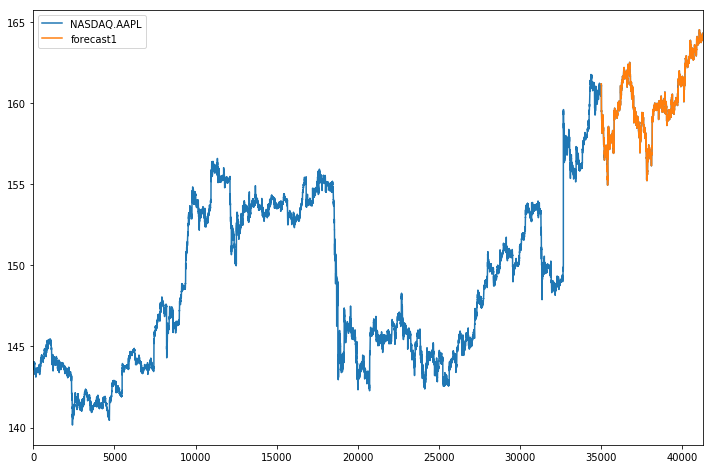

In [28]:
# pred = result.predict(35001,typ='levels')
#x = [i for i in range(41265)]
#plt.plot(x[20000:],data[20001:] ,label='Data')
#plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
#plt.title("NASDAQ ADP prediction")
#plt.xlabel('Data Index')
#plt.ylabel('StockPrice')
#plt.legend()
#plt.show()

timeseries['forecast1'] = s_arima_results.predict(start=35001, end=41265)
timeseries[['NASDAQ.AAPL','forecast1']].plot(figsize=(12,8))

### NASDAQ.ADP - Autocorrelation, Partial Autocorrelation Plots, ARIMA and Prediction

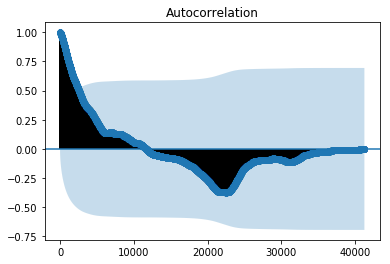

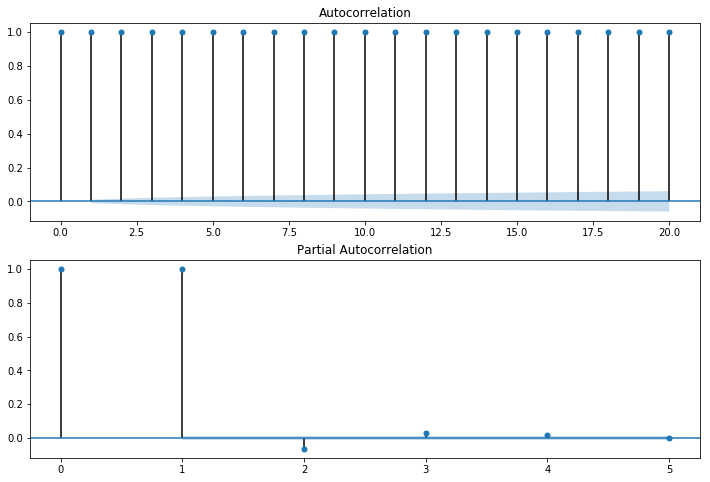

In [73]:
fig_first = plot_acf(timeseries["NASDAQ.ADP"])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries["NASDAQ.ADP"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries["NASDAQ.ADP"],lags=5, ax=ax2)

In [29]:
# data = np.array(timeseries["NASDAQ.ADP"],'f')
s_arima_model = sm.tsa.statespace.SARIMAX(timeseries["NASDAQ.ADP"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         NASDAQ.ADP   No. Observations:                41266
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               48719.644
Date:                            Mon, 19 Aug 2019   AIC                         -97431.288
Time:                                    09:30:30   BIC                         -97396.778
Sample:                                         0   HQIC                        -97420.380
                                          - 41266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0577      0.000    132.171      0.000       0.057       0.059
ma.L2         -0.0201      0.001   

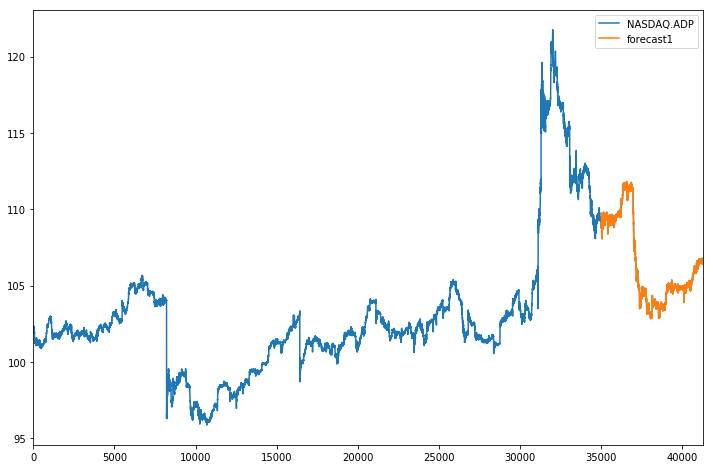

In [30]:
timeseries['forecast1'] = s_arima_results.predict(start=35001, end=41265)
timeseries[['NASDAQ.ADP','forecast1']].plot(figsize=(12,8))

### NASDAQ.CBOE - Autocorrelation, Partial Autocorrelation Plots, ARIMA and Prediction

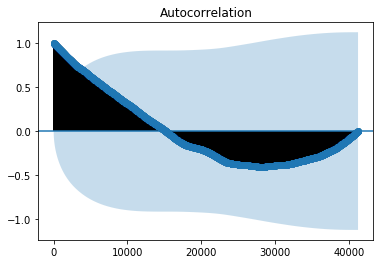

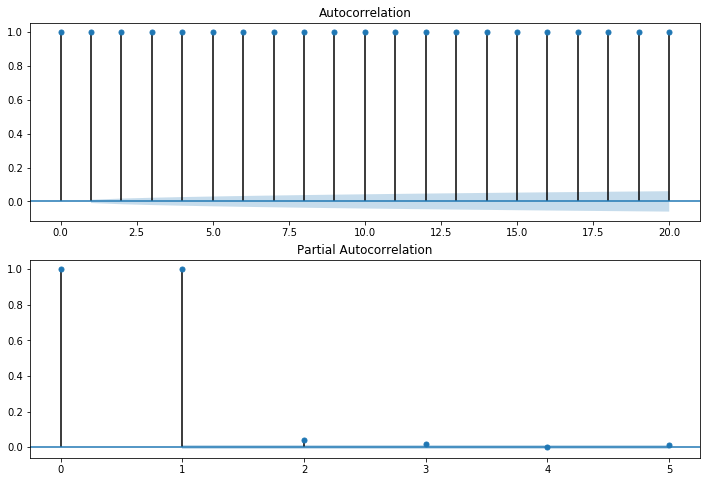

In [74]:
fig_first = plot_acf(timeseries["NASDAQ.CBOE"])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries["NASDAQ.CBOE"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries["NASDAQ.CBOE"],lags=5, ax=ax2)

In [31]:
#data = np.array(timeseries["NASDAQ.CBOE"],'f')
s_arima_model = sm.tsa.statespace.SARIMAX(timeseries["NASDAQ.CBOE"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        NASDAQ.CBOE   No. Observations:                41266
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               68073.324
Date:                            Mon, 19 Aug 2019   AIC                        -136138.648
Time:                                    09:32:00   BIC                        -136104.138
Sample:                                         0   HQIC                       -136127.741
                                          - 41266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0811      0.001    -66.614      0.000      -0.084      -0.079
ma.L2         -0.0494      0.002   

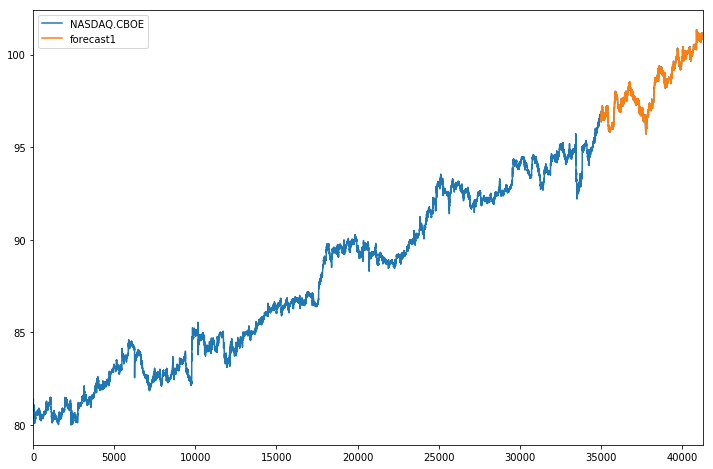

In [32]:
timeseries['forecast1'] = s_arima_results.predict(start=35001, end=41265)
timeseries[['NASDAQ.CBOE','forecast1']].plot(figsize=(12,8))

### NASDAQ.CSCO - Autocorrelation, Partial Autocorrelation Plots, ARIMA and Prediction

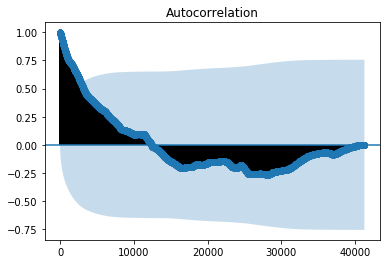

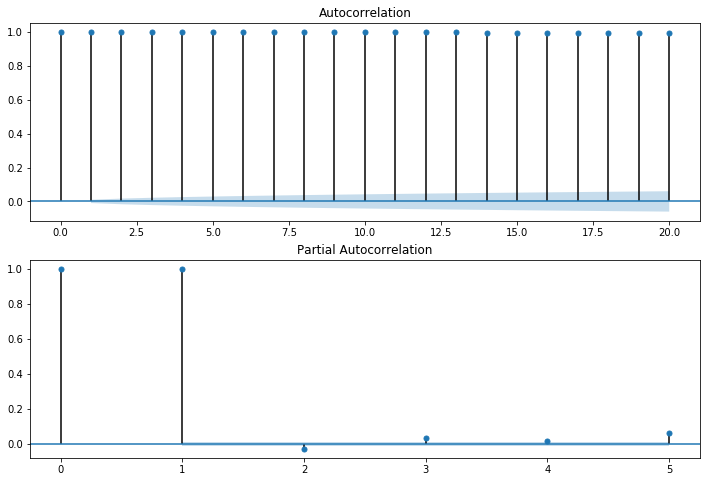

In [77]:
fig_first = plot_acf(timeseries["NASDAQ.CSCO"])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries["NASDAQ.CSCO"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries["NASDAQ.CSCO"],lags=5, ax=ax2)

In [33]:
# data = np.array(timeseries["NASDAQ.CSCO"],'f')
s_arima_model = sm.tsa.statespace.SARIMAX(timeseries["NASDAQ.CSCO"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        NASDAQ.CSCO   No. Observations:                41266
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood              100111.270
Date:                            Mon, 19 Aug 2019   AIC                        -200214.540
Time:                                    09:33:20   BIC                        -200180.030
Sample:                                         0   HQIC                       -200203.632
                                          - 41266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0146      0.001     18.475      0.000       0.013       0.016
ma.L2         -0.0412      0.002   

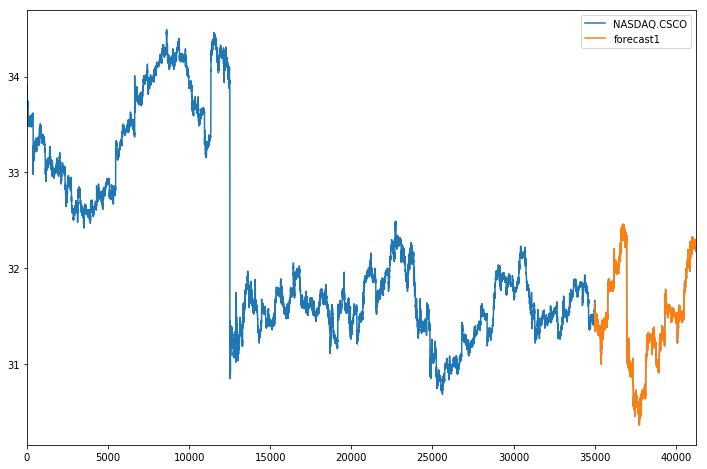

In [34]:
timeseries['forecast1'] = s_arima_results.predict(start=35001, end=41265)
timeseries[['NASDAQ.CSCO','forecast1']].plot(figsize=(12,8))

### NASDAQ.EBAY - Autocorrelation, Partial Autocorrelation Plots, ARIMA and Prediction

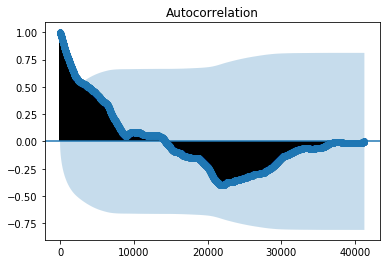

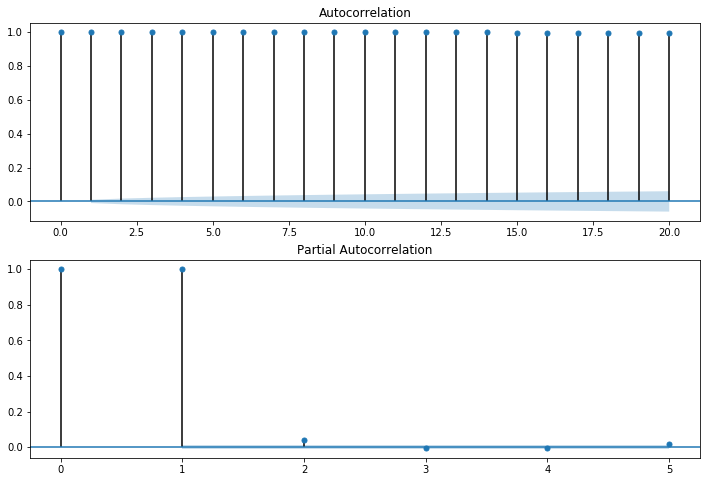

In [80]:
fig_first = plot_acf(timeseries["NASDAQ.EBAY"])
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries["NASDAQ.EBAY"], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries["NASDAQ.EBAY"],lags=5, ax=ax2)

In [35]:
# data = np.array(timeseries["NASDAQ.EBAY"],'f')
s_arima_model = sm.tsa.statespace.SARIMAX(timeseries["NASDAQ.EBAY"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        NASDAQ.EBAY   No. Observations:                41266
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               96650.786
Date:                            Mon, 19 Aug 2019   AIC                        -193293.571
Time:                                    09:35:07   BIC                        -193259.061
Sample:                                         0   HQIC                       -193282.663
                                          - 41266                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0412      0.001    -36.038      0.000      -0.043      -0.039
ma.L2          0.0088      0.002   

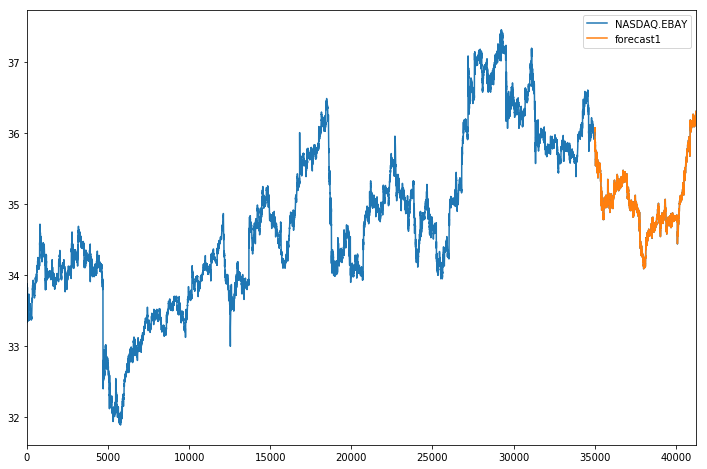

In [36]:
timeseries['forecast1'] = s_arima_results.predict(start=35001, end=41265)
timeseries[['NASDAQ.EBAY','forecast1']].plot(figsize=(12,8))

### AUTO ARIMA

In [24]:
import pmdarima as pm 
model = pm.auto_arima(
    timeseries["NASDAQ.AAPL"],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    d=1,
    start_P=0,
    seasonal=True,
    m=12,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    transparams=False
    )
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-78111.979, BIC=-78068.843, Fit time=114.415 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-49847.104, BIC=-49829.849, Fit time=20.234 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-61849.899, BIC=-61815.390, Fit time=3004.625 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-78244.099, BIC=-78209.591, Fit time=167.140 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-78024.548, BIC=-77981.412, Fit time=141.305 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-49844.536, BIC=-49818.654, Fit time=5.737 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-78079.433, BIC=-78036.299, Fit time=280.903 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-77963.050, BIC=-77911.288, Fit time=10345.183 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-78234.698, BIC=-78208.816,